<a href="https://colab.research.google.com/github/shreyansh273/Santander-Customer-Transaction-Prediction/blob/master/Kaggle_SCT_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing required functions**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

**Defining function for accuracy calculation**

In [39]:
def acc_metrics(model, X_train, X_test, y_train, y_test):
    print("train accuracy score = ", "%.2f" % accuracy_score(y_train,model.predict(X_train)))
    print("test accuracy score = ", "%.2f" % accuracy_score(y_test,model.predict(X_test)))
    print("test precision score = ", "%.2f" % precision_score(y_test,model.predict(X_test)))
    print("test recall score = ", "%.2f" % recall_score(y_test,model.predict(X_test)))

**Mounting to Google Drive**

In [10]:
import glob
from google.colab import drive
# Mounting drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading train and test data**

In [19]:
train = pd.read_csv("/content/drive/My Drive/DataScience/Santander_Customer_Transaction_Prediction/train.csv")
train.drop("ID_code",axis=1,inplace=True)
train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,10.8917,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,9.1738,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,19.3038,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


**Checking data types of columns**

In [ ]:
train.dtypes

target       int64
var_0      float64
var_1      float64
var_2      float64
var_3      float64
            ...   
var_195    float64
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Length: 201, dtype: object

**Basic Metrics for the variables**

In [20]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

**Checking for null values**

In [ ]:
null_values = pd.DataFrame(train.isnull().sum()).reset_index(drop=False)
null_values.columns = ["index","value"]
null_values.loc[null_values["value"]>0]

,index,value


**Checking for duplicate values**

In [21]:
np.sum(train.duplicated())

0

**Checking coorelation between the variables**

In [52]:
corr = train.corr()

**Checking for which variables the coorelation is greater than 50% with the dependent variable**

In [53]:
corr.loc[(corr["target"]>=0.5)]

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.0,0.05239,0.050343,0.05587,0.011055,0.010915,0.030979,0.066731,-0.003025,0.019584,-0.042805,-0.002213,0.022993,-0.069489,-0.055156,-0.006332,0.017283,0.008117,0.000864,0.043479,0.011291,-0.018329,-0.058483,0.060558,-0.025473,0.028477,0.013328,0.062422,-0.000582,-0.023942,0.004682,0.000638,-0.025619,0.030513,-0.044334,-0.052692,0.036567,-0.038397,0.007685,0.00097,...,-0.005135,0.004168,0.032647,0.031811,0.040997,-0.055734,-0.057773,0.030797,0.014115,-0.048382,0.047973,0.014873,-0.037976,0.042022,-0.061669,0.021692,0.007469,-0.036863,-0.019681,0.050002,0.03119,0.013714,-0.007198,-0.005467,0.048315,0.000053,-0.030421,0.014873,-0.034015,0.009212,0.055973,0.047114,-0.042858,-0.017709,-0.022838,0.028285,0.023608,-0.035303,-0.053,0.025434


**Heatmap of the coorelation matrix**

<AxesSubplot:>

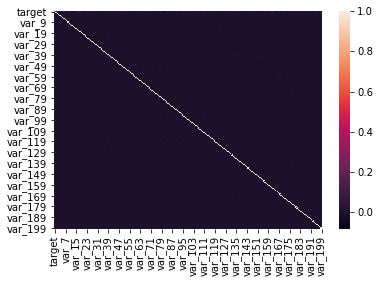

In [ ]:
sns.heatmap(corr)

**Checking the count of dependent variable**

C:\Users\Lenovo\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

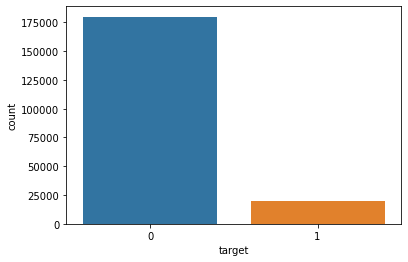

In [ ]:
sns.countplot('target', data=train)

**Bivariate analysis - checking which variables have different mean for the 2 classes of the dependent variable**

In [ ]:
init_cols = train.columns[1:]
stat_table = pd.DataFrame()
means_0 = []
means_1 = []
for i in init_cols:
    means_0.append(train[train['target']==0][i].mean())
    means_1.append(train[train['target']==1][i].mean())


<AxesSubplot:>

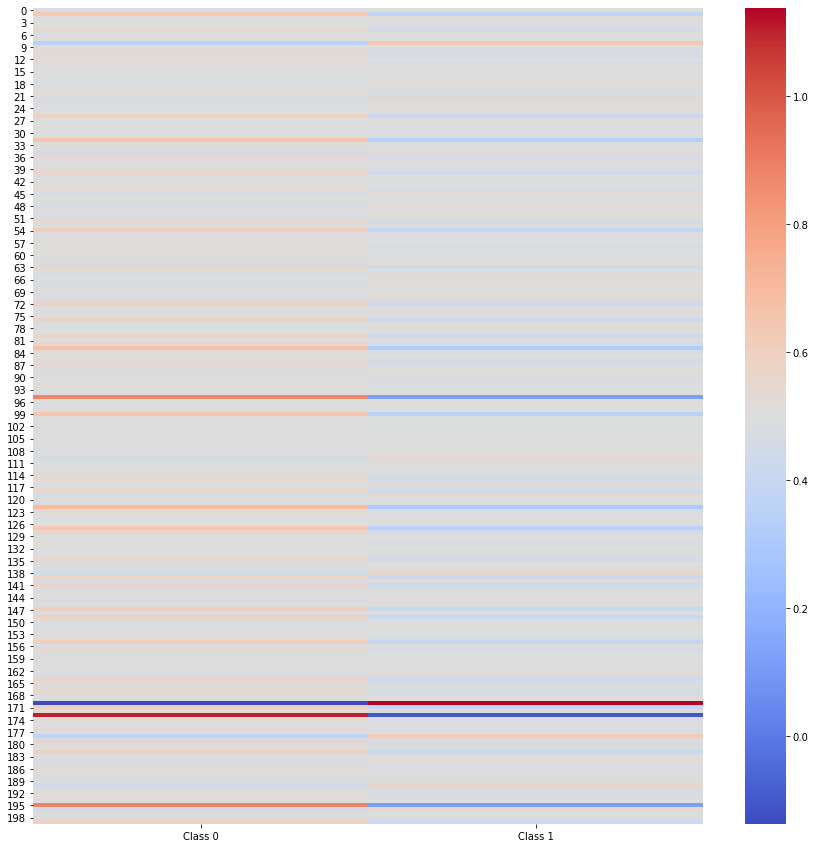

In [ ]:
stat_table["feat"] = init_cols
stat_table["0"] = means_0
stat_table["1"] = means_1
stat_table["Class 0"] = stat_table.apply(lambda x: x["0"]/(x["0"]+x["1"]), 1)
stat_table["Class 1"] = stat_table.apply(lambda x: x["1"]/(x["0"]+x["1"]), 1)
stat_table = stat_table[["feat", "Class 0", "Class 1"]]
plt.figure(figsize=(15,15))
sns.heatmap(stat_table[["Class 0", "Class 1"]], cmap='coolwarm')

In [ ]:
stat_table["var"] = stat_table.apply(lambda x: np.abs(x["Class 0"] - x["Class 1"])>0.05  , 1)
stat_table = stat_table[stat_table['var']==True]

**Undersampling the train data set**

In [22]:
n_positive = len(train.loc[train["target"]==1])
class_1_df = train.loc[train["target"]==1].copy()
class_0_df = train.loc[train["target"]==0].sample(n_positive,replace = False)
resampled_train = class_1_df.append(class_0_df, ignore_index=True)

**Splitting train dataset for training and model evaluation**

In [23]:
y = resampled_train.loc[:,train.columns == "target"]
X = resampled_train.loc[:, train.columns != "target"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28137, 200)
(12059, 200)
(28137, 1)
(12059, 1)


**Scaling train and test data**

In [35]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

**Logistic Regression model**

In [37]:
logistic = LogisticRegression()
model1 = logistic.fit(X_train_scaled,  y_train["target"])

In [40]:
acc_metrics(model1, X_train_scaled, X_test_scaled, y_train, y_test)

train accuracy score =  0.78
test accuracy score =  0.77
test precision score =  0.77
test recall score =  0.77


**Random Forests model**

In [43]:
rf = RandomForestClassifier()
model2 = rf.fit(X_train_scaled, y_train["target"])

In [44]:
acc_metrics(model2, X_train_scaled, X_test_scaled, y_train, y_test)

train accuracy score =  1.00
test accuracy score =  0.74
test precision score =  0.74
test recall score =  0.75


**Gradient Boosting model**

In [45]:
gbm = GradientBoostingClassifier()
model3 = gbm.fit(X_train_scaled, y_train["target"])

In [46]:
acc_metrics(model3, X_train_scaled, X_test_scaled, y_train, y_test)

train accuracy score =  0.80
test accuracy score =  0.75
test precision score =  0.76
test recall score =  0.72


**XGB model**

In [47]:
xgb = xgb.XGBClassifier()
model4 = xgb.fit(X_train_scaled,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
acc_metrics(model4, X_train_scaled, X_test_scaled, y_train, y_test)

train accuracy score =  0.80
test accuracy score =  0.75
test precision score =  0.76
test recall score =  0.72
